# Imports

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Custom Dataset

In [5]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, img_dir):
        img_dir = BASE_DATASET_PATH + "/" + img_dir + "/"

        path_list = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)

        self.img_dir = img_dir
        self.img_list = [os.path.join(abspath, path) for path in path_list]

        self.transform = transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), # normalize image between -1 and 1
        ])

    def __len__(self):
        return len(self.img_list)


    def __getitem__(self, idx):
        path = self.img_list[idx]
        img = Image.open(path).convert('RGB')

        img_tensor = self.transform(img)
        return img_tensor

# Discriminator Class

In [6]:
class Discriminator(nn.Module):
    def __init__(self,conv_dim=32):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, conv_dim, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(conv_dim, conv_dim*2, 4, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(conv_dim*2, conv_dim*4, 4, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(conv_dim*4, conv_dim*8, 4, padding=1),
            nn.InstanceNorm2d(conv_dim*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(conv_dim*8, 1, 4, padding=1),
        )

    def forward(self, x):
        x = self.main(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = torch.flatten(x, 1)
        return x

# ResidualBlock Class

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.main = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.main(x)

# Generator Class

In [8]:
class Generator(nn.Module):
    def __init__(self, conv_dim=64, n_res_block=9):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, conv_dim, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(conv_dim, conv_dim*2, 3, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(conv_dim*2, conv_dim*4, 3, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*4),
            nn.ReLU(inplace=True),

            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),

            nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(conv_dim*2, conv_dim, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(conv_dim),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(conv_dim, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# CycleGAN Class

In [15]:
class CycleGAN(torch.nn.Module):


    def __init__(self, g_conv_dim=64, d_conv_dim=64, n_res_block=6):
        super(CycleGAN, self).__init__()
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

        self.G_XtoY = Generator(conv_dim=g_conv_dim, n_res_block=n_res_block).to(self.device)
        self.G_YtoX = Generator(conv_dim=g_conv_dim, n_res_block=n_res_block).to(self.device)

        self.D_X = Discriminator(conv_dim=d_conv_dim).to(self.device)
        self.D_Y = Discriminator(conv_dim=d_conv_dim).to(self.device)

        print(f"Models running of {self.device}")
    def forward(self, x):
        return x

    def load_model(self, filename):
        save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
        return torch.load(save_filename)

    def real_mse_loss(self, D_out):
        return torch.mean((D_out-1)**2)


    def fake_mse_loss(self, D_out):
        return torch.mean(D_out**2)


    def cycle_consistency_loss(self, real_img, reconstructed_img, lambda_weight):
        reconstr_loss = torch.mean(torch.abs(real_img - reconstructed_img))
        return lambda_weight*reconstr_loss


    def train_generator(self, optimizers, images_x, images_y):
        # Generator YtoX
        optimizers["g_optim"].zero_grad()

        fake_images_x = self.G_YtoX(images_y)

        d_real_x = self.D_X(fake_images_x)
        g_YtoX_loss = self.real_mse_loss(d_real_x)

        recon_y = self.G_XtoY(fake_images_x)
        recon_y_loss = self.cycle_consistency_loss(images_y, recon_y, lambda_weight=10)


        # Generator XtoY
        fake_images_y = self.G_XtoY(images_x)

        d_real_y = self.D_Y(fake_images_y)
        g_XtoY_loss = self.real_mse_loss(d_real_y)

        recon_x = self.G_YtoX(fake_images_y)
        recon_x_loss = self.cycle_consistency_loss(images_x, recon_x, lambda_weight=10)

        g_total_loss = g_YtoX_loss + g_XtoY_loss + recon_y_loss + recon_x_loss
        g_total_loss.backward()
        optimizers["g_optim"].step()

        return g_total_loss.item()


    def train_discriminator(self, optimizers, images_x, images_y):
        # Discriminator x
        optimizers["d_x_optim"].zero_grad()

        d_real_x = self.D_X(images_x)
        d_real_loss_x = self.real_mse_loss(d_real_x)

        fake_images_x = self.G_YtoX(images_y)

        d_fake_x = self.D_X(fake_images_x)
        d_fake_loss_x = self.fake_mse_loss(d_fake_x)

        d_x_loss = d_real_loss_x + d_fake_loss_x
        d_x_loss.backward()
        optimizers["d_x_optim"].step()


        # Discriminator y
        optimizers["d_y_optim"].zero_grad()

        d_real_y = self.D_Y(images_y)
        d_real_loss_x = self.real_mse_loss(d_real_y)

        fake_images_y = self.G_XtoY(images_x)

        d_fake_y = self.D_Y(fake_images_y)
        d_fake_loss_y = self.fake_mse_loss(d_fake_y)

        d_y_loss = d_real_loss_x + d_fake_loss_y
        d_y_loss.backward()
        optimizers["d_y_optim"].step()

        return d_x_loss.item(), d_y_loss.item()


    def train(self, optimizers, data_loader_x, data_loader_y, print_every=10, sample_every=100):
        losses = []
        g_total_loss_min = np.Inf

        fixed_x = next(iter(data_loader_x))[1].to(self.device)
        fixed_y = next(iter(data_loader_y))[1].to(self.device)

        print(f'Running on {self.device}')
        for epoch in range(EPOCHS):
            for (images_x, images_y) in zip(data_loader_x, data_loader_y):
                images_x, images_y = images_x.to(self.device), images_y.to(self.device)

                g_total_loss = self.train_generator(optimizers, images_x, images_y)
                d_x_loss, d_y_loss = self.train_discriminator(optimizers, images_x, images_y)


            if epoch % print_every == 0:
                losses.append((d_x_loss, d_y_loss, g_total_loss))
                print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'
                .format(
                    epoch,
                    EPOCHS,
                    d_x_loss,
                    d_y_loss,
                    g_total_loss
                ))

            if g_total_loss < g_total_loss_min:
                g_total_loss_min = g_total_loss

                torch.save(self.G_XtoY.state_dict(), "G_X2Y")
                torch.save(self.G_YtoX.state_dict(), "G_Y2X")

                torch.save(self.D_X.state_dict(), "D_X")
                torch.save(self.D_Y.state_dict(), "D_Y")

                print("Models Saved")



        return losses

# Config

In [15]:
BASE_DATASET_PATH = "/content/drive/MyDrive/SE355/Đồ án/Datasets/"
X_DATASET = "trainA"
Y_DATASET = "trainB"
BATCH_SIZE = 32
N_WORKERS = 0

IMG_SIZE = 128
LR = 0.0002
BETA1 = 0.5
BETA2 = 0.999

EPOCHS = 100

# Train

In [16]:
# Dataset
x_dataset = Dataset(X_DATASET)
y_dataset = Dataset(Y_DATASET)

data_loader_x = DataLoader(x_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
data_loader_y = DataLoader(y_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

# Model
cycleGan = CycleGAN()

# Oprimizer
g_params = list(cycleGan.G_XtoY.parameters()) + list(cycleGan.G_YtoX.parameters())

optimizers = {
    "g_optim": optim.Adam(g_params, LR, [BETA1, BETA2]),
    "d_x_optim": optim.Adam(cycleGan.D_X.parameters(), LR, [BETA1, BETA2]),
    "d_y_optim": optim.Adam(cycleGan.D_Y.parameters(), LR, [BETA1, BETA2])
}

# Train
losses = cycleGan.train(optimizers, data_loader_x, data_loader_y, print_every=1)

Models running of cuda
Running on cuda
Epoch [    0/  100] | d_X_loss: 0.3293 | d_Y_loss: 0.2014 | g_total_loss: 7.2907
Models Saved
Epoch [    1/  100] | d_X_loss: 0.6013 | d_Y_loss: 0.4758 | g_total_loss: 6.2573
Models Saved
Epoch [    2/  100] | d_X_loss: 0.4687 | d_Y_loss: 0.4157 | g_total_loss: 5.8204
Models Saved
Epoch [    3/  100] | d_X_loss: 0.3055 | d_Y_loss: 0.3188 | g_total_loss: 5.1253
Models Saved
Epoch [    4/  100] | d_X_loss: 0.2297 | d_Y_loss: 0.9627 | g_total_loss: 7.3088
Epoch [    5/  100] | d_X_loss: 0.4744 | d_Y_loss: 0.2463 | g_total_loss: 6.6186
Epoch [    6/  100] | d_X_loss: 0.3899 | d_Y_loss: 0.2909 | g_total_loss: 5.7310
Epoch [    7/  100] | d_X_loss: 0.4701 | d_Y_loss: 0.2682 | g_total_loss: 6.1345
Epoch [    8/  100] | d_X_loss: 0.8696 | d_Y_loss: 0.3889 | g_total_loss: 6.4663
Epoch [    9/  100] | d_X_loss: 0.4461 | d_Y_loss: 0.3082 | g_total_loss: 4.4448
Models Saved
Epoch [   10/  100] | d_X_loss: 0.3437 | d_Y_loss: 0.2886 | g_total_loss: 6.0186
Epoch

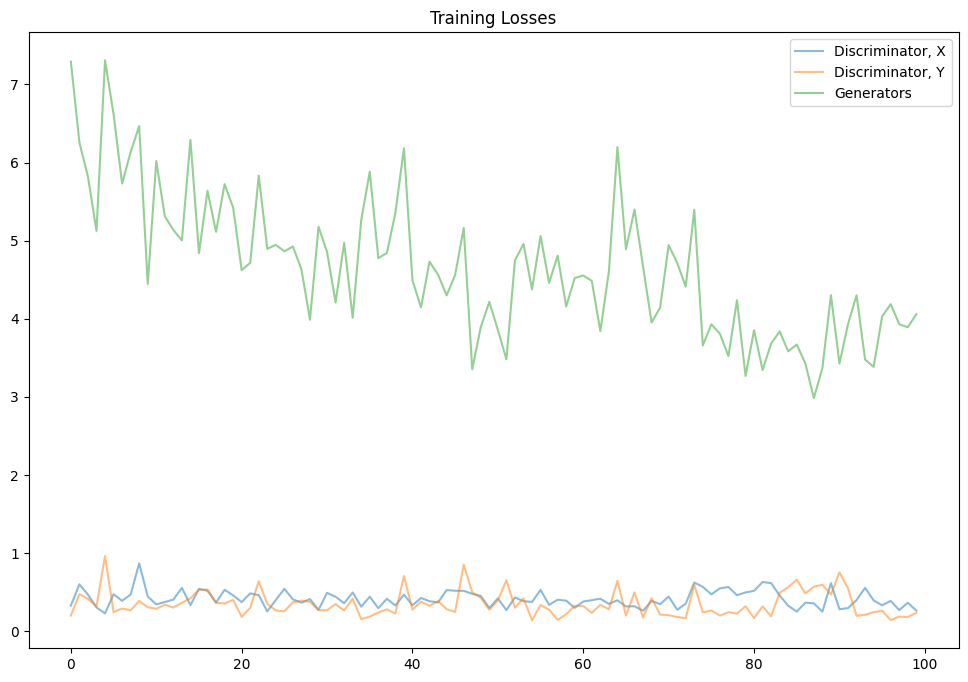

In [17]:
# Plot
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()
plt.show()

In [18]:
# Test Dataset
x_dataset = Dataset("testA")
y_dataset = Dataset("testB")

data_loader_x = DataLoader(x_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
data_loader_y = DataLoader(y_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

samples = []

for i in range(12):
    fixed_x = next(iter(data_loader_x))[i].to(cycleGan.device)
    fake_y = cycleGan.G_XtoY(torch.unsqueeze(fixed_x, dim=0))
    samples.extend([fixed_x, torch.squeeze(fake_y, 0)])

# Test Results

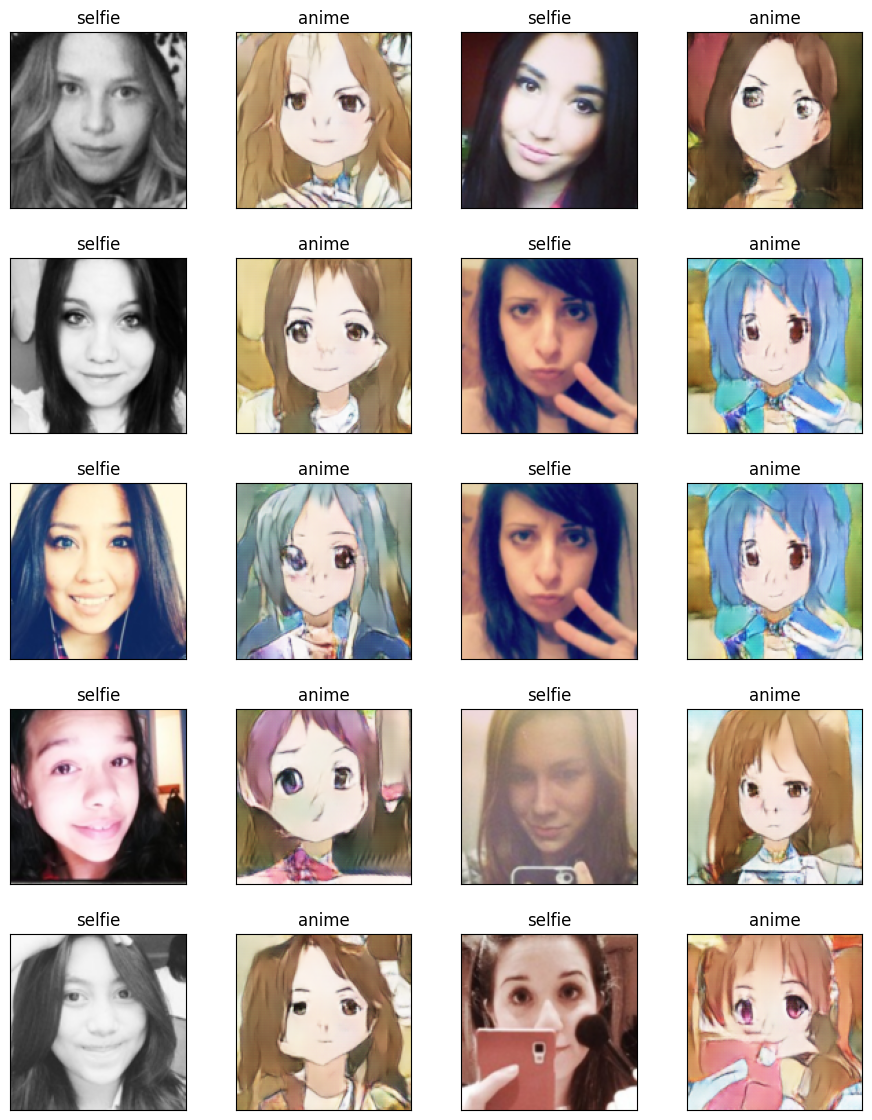

In [19]:
fig = plt.figure(figsize=(18, 14))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 4), axes_pad=0.5)


for i, (ax, im) in enumerate(zip(grid, samples)):
    _, w, h = im.size()
    im = im.detach().cpu().numpy()
    im = np.transpose(im, (1, 2, 0))

    im = ((im +1)*255 / (2)).astype(np.uint8)
    ax.imshow(im.reshape((w,h,3)))

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if i%2 == 0: title = "selfie"
    else: title = "anime"

    ax.set_title(title)

plt.show()

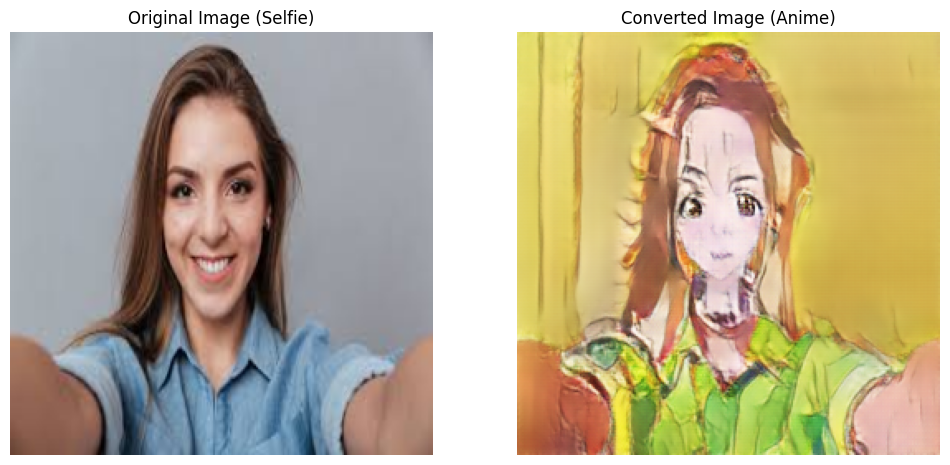

In [27]:
# Define the transformation for the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1] range
])

# Load your own image
image_path = "/content/drive/MyDrive/images.jpeg"
image = Image.open(image_path).convert("RGB")
fixed_x = transform(image).unsqueeze(0).to(cycleGan.device)  # Add batch dimension

# Generate the converted image
fake_y = cycleGan.G_XtoY(fixed_x)
fake_y = torch.squeeze(fake_y, 0)  # Remove batch dimension

# Convert tensors to numpy arrays for visualization
def tensor_to_image(tensor):
    tensor = tensor.detach().cpu().numpy()
    tensor = np.transpose(tensor, (1, 2, 0))  # Rearrange channels
    tensor = ((tensor + 1) * 255 / 2).astype(np.uint8)  # Denormalize
    return tensor

# Create a subplot for original and converted images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(tensor_to_image(fixed_x.squeeze(0)))  # Original
axes[0].set_title("Original Image (Selfie)")
axes[0].axis("off")

axes[1].imshow(tensor_to_image(fake_y))  # Converted
axes[1].set_title("Converted Image (Anime)")
axes[1].axis("off")

plt.show()